In [1]:
from dali.pipeline import Pipeline
import dali.ops as ops
import dali.types as types
import numpy as np
from timeit import default_timer as timer

image_folder = "/data/dali/benchmark/benchmark_images"

def read_jpegs(folder):
    with open(folder + "/image_list.txt", 'r') as file:
        files = [line.rstrip() for line in file]

    images = []
    for fname in files:
        f = open(image_folder + "/" + fname, 'rb')
        images.append(np.fromstring(f.read(), dtype = np.uint8))
    return images

def make_batch(size):
    data = read_jpegs(image_folder)
    return [data[i % len(data)] for i in range(size)]

class C2Pipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(C2Pipe, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = ops.ExternalSource()
        self.decode = ops.HostDecoder(output_type = types.RGB)
        self.rcm = ops.FastResizeCropMirror(crop = [224, 224])
        self.np = ops.NormalizePermute(device = "gpu",
                                       output_dtype = types.FLOAT16,
                                       mean = [128., 128., 128.],
                                       std = [1., 1., 1.],
                                       height = 224,
                                       width = 224,
                                       image_type = types.RGB)
        self.uniform = ops.Uniform(range = (0.0, 1.0))
        self.res_uniform = ops.Uniform(range = (256.,480.))
        self.iter = 0

    def define_graph(self):
        self.jpegs = self.input()
        images = self.decode(self.jpegs)
        resized = self.rcm(images, crop_pos_x = self.uniform(),
                           crop_pos_y = self.uniform(),
                           resize_shorter = self.res_uniform())
        output = self.np(resized.gpu())
        return output

    def iter_setup(self):
        if self.iter == 0:
            raw_data = make_batch(self.batch_size)
            self.feed_input(self.jpegs, raw_data)
            self.iter += 1

class HybridPipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(HybridPipe, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = ops.ExternalSource()
        self.decode = ops.nvJPEGDecoder(device = "mixed", output_type = types.RGB)
        self.resize = ops.Resize(device = "gpu", random_resize = True,
                                 resize_a = 256, resize_b = 480,
                                 image_type = types.RGB,
                                 interp_type = types.INTERP_LINEAR)
        self.cmnp = ops.CropMirrorNormalize(device = "gpu",
                                            output_dtype = types.FLOAT,
                                            crop = (224, 224),
                                            image_type = types.RGB,
                                            mean = [128., 128., 128.],
                                            std = [1., 1., 1.])
        self.uniform = ops.Uniform(range = (0.0, 1.0))
        self.iter = 0

    def define_graph(self):
        self.jpegs = self.input()
        images = self.decode(self.jpegs)
        resized = self.resize(images)
        output = self.cmnp(resized, crop_pos_x = self.uniform(),
                           crop_pos_y = self.uniform())
        return output

    def iter_setup(self):
        if self.iter == 0:
            raw_data = make_batch(self.batch_size)
            self.feed_input(self.jpegs, raw_data)
            self.iter += 1

def run_benchmarks(PipeType, args):
    print("Running Benchmarks For {}".format(PipeType.__name__))
    for batch_size in args.batch_sizes:
        for num_threads in args.thread_counts:
            pipe = PipeType(batch_size, num_threads, 0)
            pipe.build()
            start_time = timer()
            for i in range(args.num_iters):
                pipe.run()

            total_time = timer() - start_time
            print("{}/{}/{}: FPS={}"
                    .format(PipeType.__name__,  batch_size, num_threads,
                            float(batch_size * args.num_iters) / total_time))
class Struct:
    def __init__(self, **entries): self.__dict__.update(entries)

def test():
    args = Struct(batch_sizes=[128], thread_counts=[1,2,3,4], num_iters=100)
    pipe_types = [C2Pipe, HybridPipe]
    for PipeType in pipe_types:
        run_benchmarks(PipeType, args)

In [ ]:
test()

In [3]:
n = 15

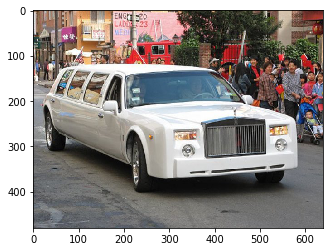

In [4]:
import numpy as np
a = np.array(make_batch(128))
import cv2
b = cv2.imdecode(a[n], cv2.IMREAD_COLOR)
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(b, cv2.COLOR_BGR2RGB))

In [5]:
pipe = HybridPipe(batch_size=128, num_threads=4, device_id = 0)
pipe.build()

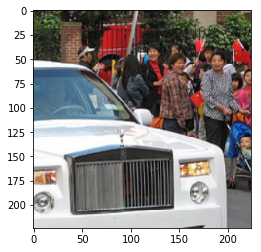

In [6]:
pipe_out = pipe.run()
pipe_out_cpu = pipe_out[0].asCPU()
img_chw = pipe_out_cpu.at(n)
%matplotlib inline
plt.imshow((np.transpose(img_chw, (1,2,0))+128)/255.0)